In [1]:
import numpy as np

data = np.load('../processed_data/10_split_dataset/data.npz', allow_pickle=True)
label = np.load('../processed_data/10_split_dataset/label.npz.npy')

In [2]:
X = np.stack([data[f'arr_{i}'].item()['three_sec'] for i in range(len(data))])
X_30sec = np.stack([data[f'arr_{i}'].item()['thirty_sec'] for i in range(len(data))])
label = label
RANDOM_STATE = 42

In [3]:
import numpy as np

def generate_k_fold_dataset(data_3sec, data_30sec, label, k, shrink_ratio=1.0, shuffle_train_data=True, random_state=42):
    np.random.seed(random_state)
    numbers = np.arange(data_3sec.shape[0])
    np.random.shuffle(numbers)
    test_indices = np.array_split(numbers, k)
    
    train_folds, test_3sec_folds, test_30sec_folds = [], [], []
    for i in range(k):
        mask = np.zeros(data_3sec.shape[0], dtype=bool)
        mask[test_indices[i]] = True
        
        X_train, y_train = data_3sec[~mask], label[~mask]
        if shuffle_train_data:
            shuffle_indices = np.arange(X_train.shape[0])
            np.random.shuffle(shuffle_indices)
            X_train, y_train = X_train[shuffle_indices], y_train[shuffle_indices]
        
        X_3sec_test, y_3sec_test = data_3sec[mask], label[mask]
        X_30sec_test, y_30sec_test = data_30sec[mask], label[mask]
        
        train_folds.append((X_train[:int(shrink_ratio * len(X_train))], y_train[:int(shrink_ratio * len(y_train))]))
        test_3sec_folds.append((X_3sec_test, y_3sec_test))
        test_30sec_folds.append((X_30sec_test, y_30sec_test))
    
    if shrink_ratio != 1.0:
        print(f'Warning: shrink_ratio is set to {shrink_ratio}, the dataset is shrinked.')
        print(f'X_train=({train_folds[0][0].shape}, y_train=({train_folds[0][1].shape}), X_3sec_test=({test_30sec_folds[0][0].shape}, y_3sec_test=({test_30sec_folds[0][1].shape})')
    return train_folds, test_3sec_folds, test_30sec_folds
        
train_folds, test_3sec_folds, test_30sec_folds = generate_k_fold_dataset(X, X_30sec, label, 10, shrink_ratio=1.0, shuffle_train_data=False)

In [4]:
from scipy import stats
from sklearn.svm import SVC


def predict_and_mode(model, X_test, scaler, threshold=0.6):
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    results = model.predict(X_test_scaled.reshape(-1, X_test.shape[-1]))
    results = results.reshape(X_test.shape[:-1])
    final_results = stats.mode(results, axis=1)
    return final_results.mode.flatten()

In [5]:
def predict_naive(model, X_test, scaler):
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    results = model.predict(X_test_scaled.reshape(-1, X_test.shape[-1]))

    return results

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def aggregate_metrics(y_true, y_pred):
    return accuracy_score(y_true, y_pred),\
        precision_score(y_true, y_pred, average='macro', zero_division=0.),\
        recall_score(y_true, y_pred, average='macro', zero_division=0.),\
        f1_score(y_true, y_pred, average='macro', zero_division=0.)

In [7]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def perform_experiment(model_type, train_folds, test_3sec_folds, test_30sec_folds, fold_idx,
                       type_return='report', **model_args):
    
    if type_return not in ['report', 'metrics', 'confusion_matrix']:
        raise ValueError("Invalid return_type. Must be either 'report', 'metrics', or 'conf_matrix'.")
    
    X_train, y_train = train_folds[fold_idx]
    X_test, y_test = test_3sec_folds[fold_idx]
    X_test_30sec, y_test_30sec = test_30sec_folds[fold_idx]

    rand_perm = np.random.permutation(np.arange(X_test.shape[0]))
    X_test, y_test = X_test[rand_perm], y_test[rand_perm]
    X_test_30sec, y_test_30sec = X_test_30sec[rand_perm], y_test_30sec[rand_perm]
    
    y_train = np.repeat(y_train, X_train.shape[1])
    X_train = X_train.reshape(-1, X_train.shape[-1])

    rand_perm = np.random.permutation(np.arange(X_train.shape[0]))
    X_train, y_train = X_train[rand_perm], y_train[rand_perm]
    
    scalar = StandardScaler()
    X_train = scalar.fit_transform(X_train)

    # Change the model here to experiment with different models
    # model = SVC(kernel='rbf', decision_function_shape='ovo', C=1, probability=True, random_state=RANDOM_STATE)
    # model = MLPClassifier(hidden_layer_sizes=(128, 128, 10), max_iter=1000, random_state=RANDOM_STATE)
    # model = RandomForestClassifier(max_features=20, max_depth=10)
    model = model_type(**model_args)

    # model = RandomForestClassifier(max_features=20, max_depth=10)
    model.fit(X_train, y_train)

    # print(X_test.shape, X_test_30sec.shape)

    X_test = np.concatenate((X_test, X_test_30sec[:, None, :]), axis=1)
    # print(X_test.shape)

    if type_return == 'report':
        train_report = classification_report(y_train, model.predict(X_train))
        mode_report = classification_report(y_test, predict_and_mode(model, X_test, scalar))
        naive_report = classification_report(y_test_30sec, predict_naive(model, X_test_30sec, scalar)) 
        return train_report, mode_report, naive_report
    elif type_return == 'metrics':
        train_metrics = aggregate_metrics(y_train, model.predict(X_train))
        mode_metrics = aggregate_metrics(y_test, predict_and_mode(model, X_test, scalar))
        naive_metrics = aggregate_metrics(y_test_30sec, predict_naive(model, X_test_30sec, scalar))
        return train_metrics, mode_metrics, naive_metrics
    # elif type_return == 'confusion_matrix':
    #     train_conf_matrix = confusion_matrix(y_train, model.predict(X_train))
    #     mode_conf_matrix = confusion_matrix(y_test, predict_and_mode(model, X_test, scalar))
    #     naive_conf_matrix = confusion_matrix(y_test_30sec, predict_naive(model, X_test_30sec, scalar))
    #     return train_conf_matrix, mode_conf_matrix, naive_conf_matrix

In [8]:
accs = {}
f1s = {}

In [24]:
class_name_mapping = {
        "<class 'sklearn.linear_model._logistic.LogisticRegression'>": "Logistic",
        "<class 'sklearn.svm._classes.SVC'>": "SVM",
        "<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>": "MLP",
        "<class 'sklearn.ensemble._forest.RandomForestClassifier'>": "random forest",
        "<class 'sklearn.naive_bayes.GaussianNB'>": "GaussianNB",
        "<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>": "XGBoost"
    }

In [27]:
from tqdm import tqdm
import sys
sys.path.append('../')
from audio_toolbox import visualize_confusion_matrices

def k_fold_experiment(model, train_folds, test_3sec_folds, test_30sec_folds, **model_args):
    metrics = []
    all_conf_matrices = []
    for k in tqdm(range(len(train_folds))):
        train_metrics, mode_metrics, naive_metrics = perform_experiment(model, train_folds, test_3sec_folds, test_30sec_folds, k, type_return='metrics', **model_args)
        conf_matrix = perform_experiment(model, train_folds, test_3sec_folds, test_30sec_folds, k, type_return='confusion_matrix', **model_args)
        # print(f"Fold {k+1}:")
        # print(f"Train metrics: acc={train_metrics[0]:.3f}, precision={train_metrics[1]:.3f}, recall={train_metrics[2]:.3f}, f1={train_metrics[3]:.3f}")
        # print(f"Mode Strategy metrics: acc={mode_metrics[0]:.3f}, precision={mode_metrics[1]:.3f}, recall={mode_metrics[2]:.3f}, f1={mode_metrics[3]:.3f}")
        # print(f"Naive Strategy metrics: acc={naive_metrics[0]:.3f}, precision={naive_metrics[1]:.3f}, recall={naive_metrics[2]:.3f}, f1={naive_metrics[3]:.3f}")
        metrics.append((train_metrics, mode_metrics, naive_metrics))
        all_conf_matrices.append(conf_matrix)
    
    avg_accs = {
        "train": np.mean([m[0][0] for m in metrics], axis=0),
        "mode": np.mean([m[1][0] for m in metrics], axis=0),
        "naive": np.mean([m[2][0] for m in metrics], axis=0)
    }
    avg_precisions = {
        "train": np.mean([m[0][1] for m in metrics], axis=0),
        "mode": np.mean([m[1][1] for m in metrics], axis=0),
        "naive": np.mean([m[2][1] for m in metrics], axis=0)
    }
    avg_recalls = {
        "train": np.mean([m[0][2] for m in metrics], axis=0),
        "mode": np.mean([m[1][2] for m in metrics], axis=0),
        "naive": np.mean([m[2][2] for m in metrics], axis=0)
    }
    avg_f1s = {
        "train": np.mean([m[0][3] for m in metrics], axis=0),
        "mode": np.mean([m[1][3] for m in metrics], axis=0),
        "naive": np.mean([m[2][3] for m in metrics], axis=0)
    }
    
    print(f"Average train metrics: acc={avg_accs['train'] * 100:.2f}%," +\
          f"precision={avg_precisions['train']:.3f}," +\
          f"recall={avg_recalls['train']:.3f}," +\
          f"f1={avg_f1s['train']:.3f}")
    print(f"Average Mode Strategy metrics: acc={avg_accs['mode'] * 100:.2f}%," +\
          f"precision={avg_precisions['mode']:.3f}," +\
          f"recall={avg_recalls['mode']:.3f}," +\
          f"f1={avg_f1s['mode']:.3f}")
    
    accs[f"{model}"] = avg_accs
    f1s[f"{model}"] = avg_f1s
    
    print(f"Average Naive Strategy metrics: acc={avg_accs['naive'] * 100:.2f}%," +\
          f"precision={avg_precisions['naive']:.3f}," +\
          f"recall={avg_recalls['naive']:.3f}," +\
          f"f1={avg_f1s['naive']:.3f}")
    
    
    visualize_confusion_matrices([all_conf_matrices[0][0]],
                             titles=[f'Best Fold: {0 + 1} Mode Strategy'],
                             grand_title=f'Confusion Matrix for {model} on One Fold, Mode Strategy')

Fitting Models

100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Average train metrics: acc=75.71%,precision=0.755,recall=0.757,f1=0.755
Average Mode Strategy metrics: acc=73.37%,precision=0.723,recall=0.725,f1=0.714
Average Naive Strategy metrics: acc=72.18%,precision=0.718,recall=0.712,f1=0.705


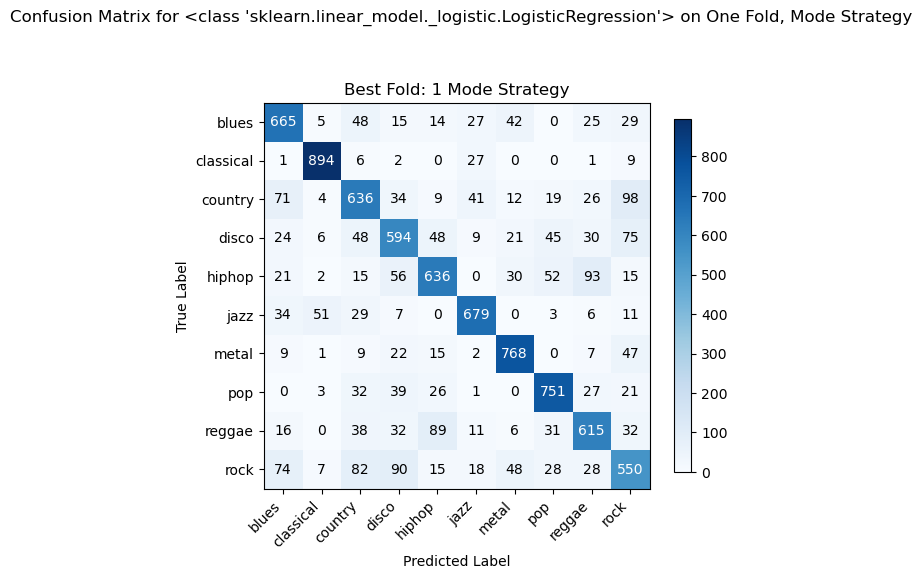

In [28]:
import warnings
# Logistic Regression
model = LogisticRegression
model_args = {
    'max_iter': 3000, 
    'C': 1e-3, 
    'random_state': RANDOM_STATE
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    k_fold_experiment(model, train_folds, test_3sec_folds, test_30sec_folds)

100%|██████████| 10/10 [02:44<00:00, 16.41s/it]


Average train metrics: acc=95.04%,precision=0.951,recall=0.950,f1=0.950
Average Mode Strategy metrics: acc=78.98%,precision=0.783,recall=0.785,f1=0.774
Average Naive Strategy metrics: acc=75.48%,precision=0.757,recall=0.741,f1=0.734


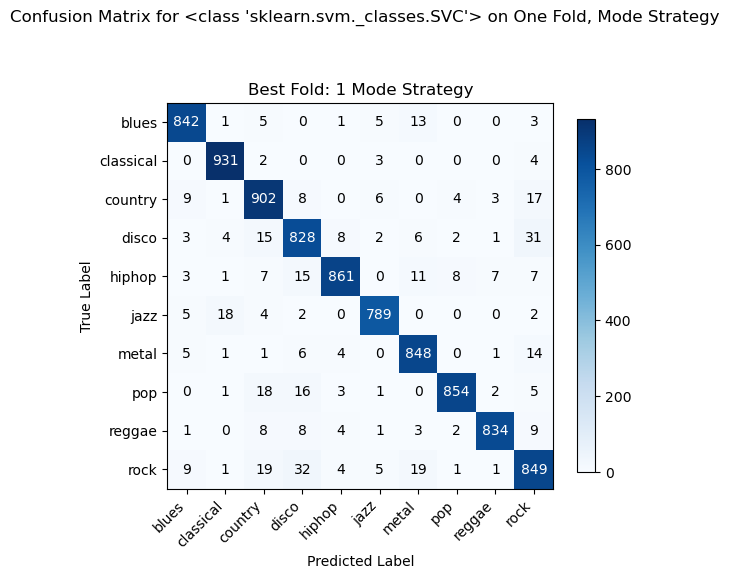

In [29]:
import warnings
# svm
model = SVC
model_args = {
    'kernel': 'linear',
    'C': 2,
    'random_state': RANDOM_STATE
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    k_fold_experiment(model, train_folds, test_3sec_folds, test_30sec_folds)

100%|██████████| 10/10 [02:49<00:00, 17.00s/it]


Average train metrics: acc=95.04%,precision=0.951,recall=0.950,f1=0.950
Average Mode Strategy metrics: acc=78.98%,precision=0.783,recall=0.785,f1=0.774
Average Naive Strategy metrics: acc=75.48%,precision=0.757,recall=0.741,f1=0.734


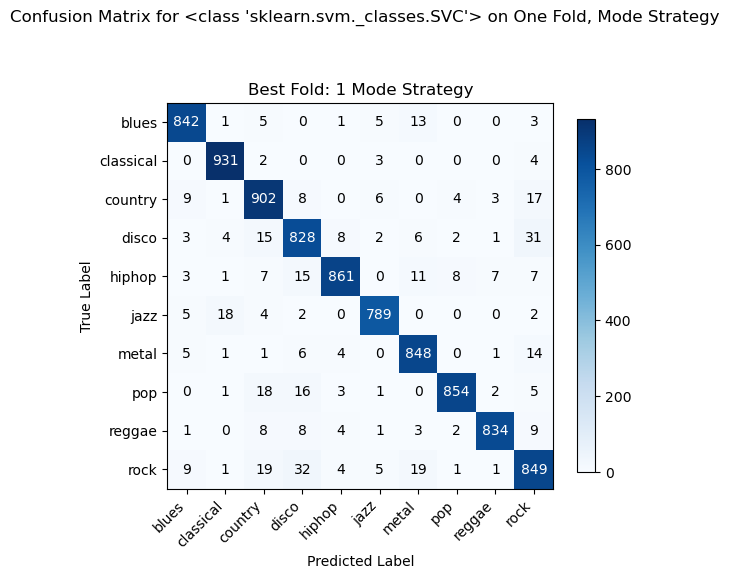

In [30]:
import warnings
# ovosvm
model = SVC
model_args = {
    'kernel': 'linear',
    'decision_function_shape': 'ovo',
    'C': 2,
    'random_state': RANDOM_STATE
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    k_fold_experiment(model, train_folds, test_3sec_folds, test_30sec_folds)

100%|██████████| 10/10 [02:04<00:00, 12.42s/it]


Average train metrics: acc=99.91%,precision=0.999,recall=0.999,f1=0.999
Average Mode Strategy metrics: acc=78.38%,precision=0.780,recall=0.781,f1=0.770
Average Naive Strategy metrics: acc=75.78%,precision=0.753,recall=0.755,f1=0.745


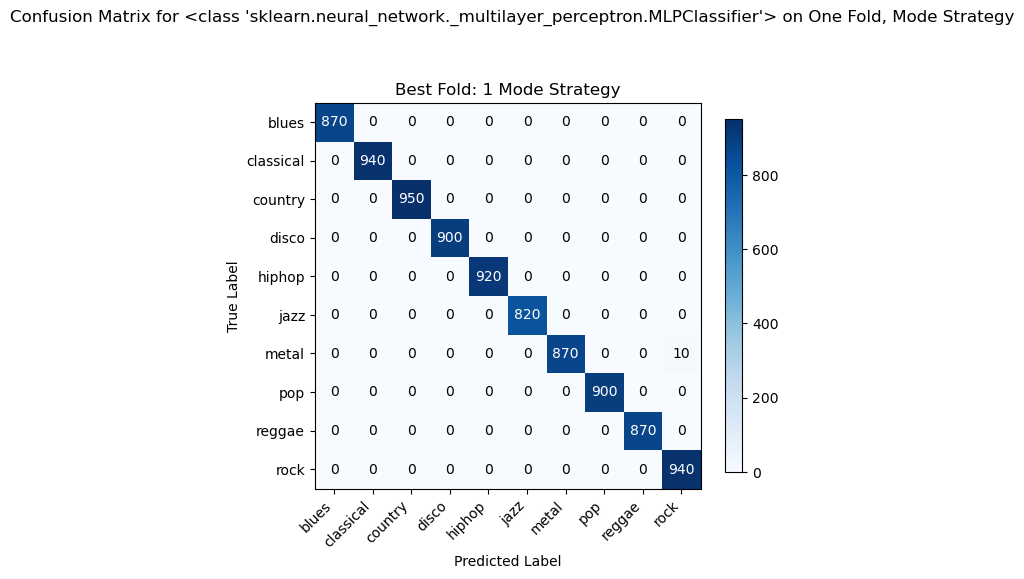

In [31]:
import warnings
# MLP
model = MLPClassifier
model_args = {
    'hidden_layer_sizes': (128, 128, 10),
    'max_iter': 1000,
    'random_state': RANDOM_STATE
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    k_fold_experiment(model, train_folds, test_3sec_folds, test_30sec_folds)

100%|██████████| 10/10 [02:11<00:00, 13.11s/it]


Average train metrics: acc=99.91%,precision=0.999,recall=0.999,f1=0.999
Average Mode Strategy metrics: acc=73.17%,precision=0.719,recall=0.723,f1=0.709
Average Naive Strategy metrics: acc=68.37%,precision=0.704,recall=0.673,f1=0.663


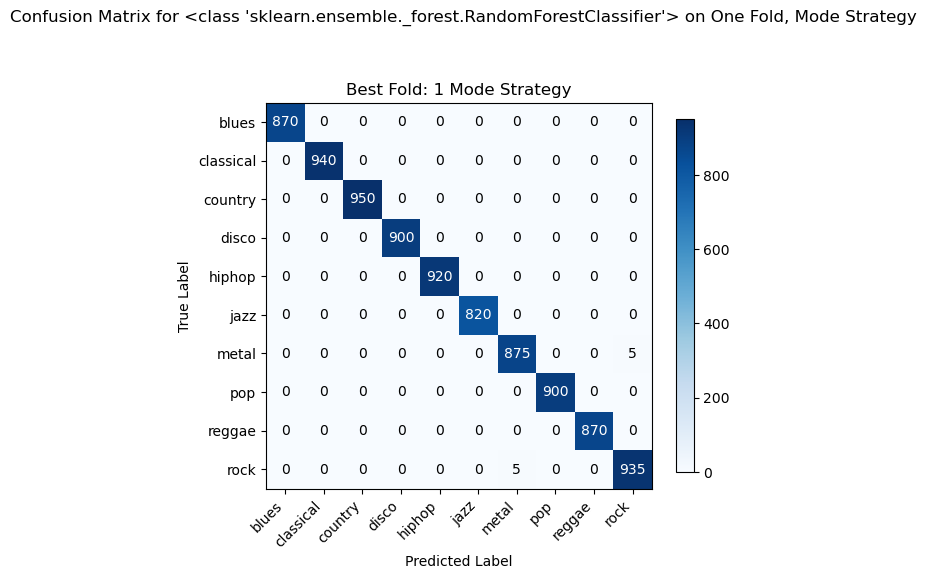

In [32]:
import warnings
# Random Forest
model = RandomForestClassifier
model_args = {
    'n_estimators': 100,
    'max_depth': 3,
    'random_state': RANDOM_STATE
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    k_fold_experiment(model, train_folds, test_3sec_folds, test_30sec_folds)

100%|██████████| 10/10 [00:01<00:00,  7.54it/s]


Average train metrics: acc=55.69%,precision=0.560,recall=0.557,f1=0.545
Average Mode Strategy metrics: acc=57.76%,precision=0.580,recall=0.570,f1=0.544
Average Naive Strategy metrics: acc=53.96%,precision=0.535,recall=0.533,f1=0.510


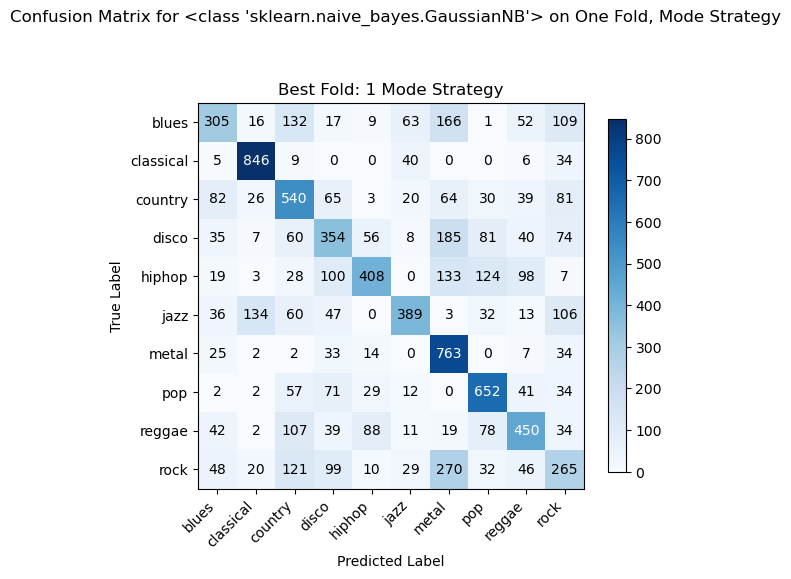

In [33]:
import warnings
# GaussianNB
model = GaussianNB
model_args = {

}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    k_fold_experiment(model, train_folds, test_3sec_folds, test_30sec_folds)

In [34]:
import warnings
# XGBoost
model = GradientBoostingClassifier
model_args = {
    'subsample': 0.8,
    'max_depth': 2,
    'random_state': RANDOM_STATE
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    k_fold_experiment(model, train_folds, test_3sec_folds, test_30sec_folds)

 80%|████████  | 8/10 [11:41:56<2:55:29, 5264.50s/it] 


KeyboardInterrupt: 

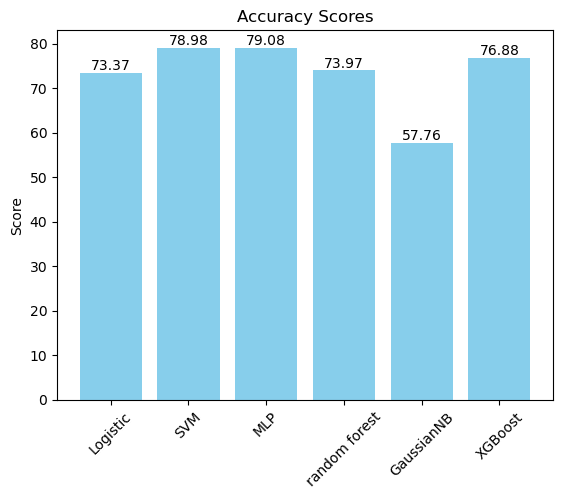

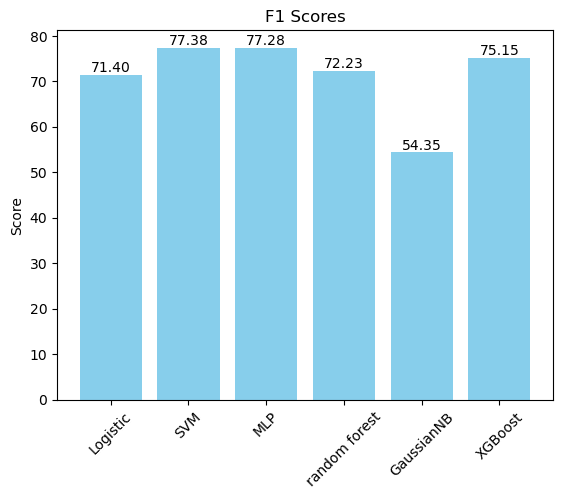

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def create_bar_chart(data, title, ylabel):
    models = list(data.keys())
    scores = list(data.values())
    fig, ax = plt.subplots()
    bar_positions = np.arange(len(models))
    ax.bar(bar_positions, scores, color='skyblue')
    for i, v in enumerate(scores):
        ax.text(i, v + 0.01, "{:.2f}".format(v), ha='center', va='bottom')

    ax.set_xticks(bar_positions)
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

class_name_mapping = {
    "<class 'sklearn.linear_model._logistic.LogisticRegression'>": "Logistic",
    "<class 'sklearn.svm._classes.SVC'>": "SVM",
    "<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>": "MLP",
    "<class 'sklearn.ensemble._forest.RandomForestClassifier'>": "random forest",
    "<class 'sklearn.naive_bayes.GaussianNB'>": "GaussianNB",
    "<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>": "XGBoost"
}

mode_accuracy_formatted = {
    class_name_mapping[class_name]: round(accs[class_name]['mode'] * 100, 2) for class_name in accs
}

mode_f1_formatted = {
    class_name_mapping[class_name]: round(f1s[class_name]['mode'] * 100, 2) for class_name in f1s
}

create_bar_chart(mode_accuracy_formatted, "Accuracy Scores", "Score")
create_bar_chart(mode_f1_formatted, "F1 Scores", "Score")